In [1]:
import datetime
import os
import glob
import numpy as np
import pandas as pd 
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap

clon=180

land_10m = cfeature.NaturalEarthFeature(
    "physical", "land", "10m", facecolor=cfeature.COLORS["land"]
)
    
def plot_decor(ax):
    ax.coastlines("10m")
    ax.set_extent([172,180,-42,-34])
    ax.add_feature(land_10m, zorder=-1)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    

def plot_1x1(da, levels, cmap, cbar_label, fig_label):
    fig, ax = plt.subplots(1,1, figsize=(8,6), subplot_kw={"projection": ccrs.PlateCarree(clon)})    
    da.plot.contourf(ax=ax, levels=levels, cmap=cmap, cbar_kwargs={'label': cbar_label}, transform=ccrs.PlateCarree())                                            
    plot_decor(ax)
    fig.suptitle(fig_label)
    return fig,ax



# Set customizable global variables

In [2]:
###################################
## Customizable global variables ##
###################################

density = 1300 # kg/m3 andesite for Tongariro
fig_args = dict(bbox_inches='tight', dpi=300)
it = -1
savefigs = True

# For operational case study 
data_pattern = 'output/lhs_gefs_sample1_202107150000/*Tongariro*nc'
fileplot_prefix = 'plt_lhs_gefs_sample1_202107150000_Tongariro'

# For historical case study 
# data_pattern = 'output/lhs_gens_3_sample_n20_1_201208061200/*Tongariro*nc'
# fileplot_prefix = 'plt_lhs_gens_3_sample_n20_1_201208061200_Tongariro'



# Read files

In [3]:
files = glob.glob(data_pattern)
files.sort()
print(len(files))

for x in files[:3]:
    print(x)


30
output/lhs_gefs_sample1_202107150000/21071500_Tongariro_sample1_gep01_idx000_20.0_0.01.nc
output/lhs_gefs_sample1_202107150000/21071500_Tongariro_sample1_gep02_idx001_10.0_0.01.nc
output/lhs_gefs_sample1_202107150000/21071500_Tongariro_sample1_gep03_idx002_6.5_0.01.nc


In [4]:
ds = xr.open_mfdataset(files, combine='nested', concat_dim=['idx'])

# Scale system's depth computation
ds['total_deposition'].data = ds['total_deposition'].data * 1e-10 / density * 1e3 # mm
ds

<xarray.Dataset>
Dimensions:           (idx: 30, lat: 1401, lon: 1401, time: 24)
Coordinates:
  * lat               (lat) float32 -48.0 -47.99 -47.98 ... -34.02 -34.01 -34.0
  * lon               (lon) float32 166.0 166.0 166.0 ... 180.0 180.0 180.0
  * time              (time) datetime64[ns] 2021-07-15T01:00:00 ... 2021-07-16
Dimensions without coordinates: idx
Data variables:
    total_deposition  (idx, time, lat, lon) float32 dask.array<chunksize=(1, 24, 1401, 1401), meta=np.ndarray>
    hz                (idx, time) timedelta64[ns] dask.array<chunksize=(1, 24), meta=np.ndarray>
Attributes:
    title:                   HYSPLIT v5.0.1
    Conventions:             CF-1.5
    eruption_time:           2021-07-15T00:00:00
    accumulation_period_h:   24
    volcano:                 Tongariro_sample1_gep01_idx000
    src_lat:                 -39.130001068115234
    src_lon:                 175.64199829101562
    plume_height_amsl_km:    20.0
    volume_km3:              0.01
    eruption_duration_hhmm:  0100

In [5]:
eruption_time = datetime.datetime.strptime(ds.attrs['eruption_time'], '%Y-%m-%dT%H:%M:%S')
print(eruption_time)
lag_hours = np.array([int(x.total_seconds()/3600.) for x in pd.to_datetime(ds.time.data) - eruption_time])
print(lag_hours)

2021-07-15 00:00:00
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


# Compute exceedance probabilities

In [6]:
def compute_arrival_time(dain, vmin):
    if dain.dims[0] != 'time':
        print(dain.shape)
        print('bad shape. Shoud be time, lat, lon')
        raise
    nt = dain.sizes['time']
    daout = xr.where(dain > vmin, 1., 0)
    daout = daout.cumsum(dim='time')
    daout = daout.where(daout > 0)
    # Assuming hourly data
    for it in range(nt):
         daout.data[it,...] = it+2 - daout.isel(time=it).data
    return daout

def compute_exc_prob_arrival_time(dain, threshold, arrival_min):
    da = xr.where(dain > threshold, 1, 0)
    da_prob = da.sum(dim='idx')/da.sizes['idx']
    da_prob_arrival_time = compute_arrival_time(da_prob, vmin=arrival_min)
    return(da_prob, da_prob_arrival_time)


In [7]:
thresholds = [0.01, 0.1, 1, 3, 10]
arrival_min = 0.5  # arrival of the 50% excedance prob

da_probs = []
da_prob_arrival_times = []
for thres in thresholds:
    da_prob, da_prob_arrival_time = compute_exc_prob_arrival_time(
        dain=ds['total_deposition'],
        threshold=thres,    
        arrival_min=arrival_min)
    da_probs += [da_prob]
    da_prob_arrival_times += [da_prob_arrival_time]

da_probs = xr.concat(da_probs, pd.Index(thresholds, name="threshold"))
da_prob_arrival_times = xr.concat(da_prob_arrival_times, pd.Index(thresholds, name="threshold"))

# Plot exceedance probability and arrival time

plt_lhs_gefs_sample1_202107150000_Tongariro_excprob0.01_arrivaltime_lag24.png
plt_lhs_gefs_sample1_202107150000_Tongariro_excprob0.01_lag24.png
Elapsed time: 57.646862 s


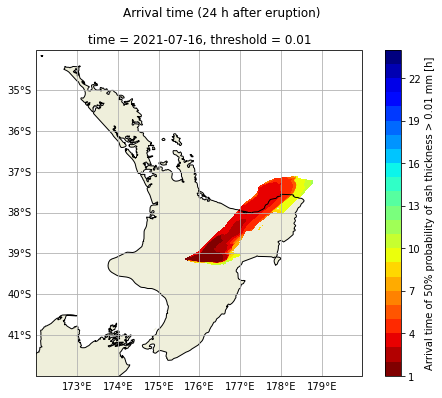

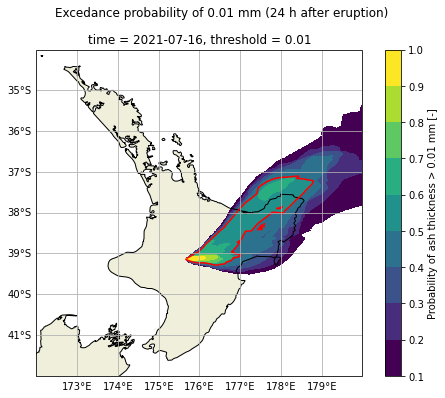

In [8]:
tic = datetime.datetime.now()

prob_levs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# prob_levs = [0.1, 0.5, 0.9, 1.]

for thres in thresholds[:1]:

    da_prob = da_probs.sel(threshold=thres)
    da_prob_arrival_time = da_prob_arrival_times.sel(threshold=thres)

    # plot arrival time
    fig, ax = plot_1x1(
        da = da_prob_arrival_time.isel(time=it),
        levels = lag_hours,
        cmap = 'jet_r',
        cbar_label = 'Arrival time of {}% probability of ash thickness > {} mm [h]'.format(int(arrival_min*100), thres),
        fig_label = 'Arrival time ({} h after eruption)'.format(lag_hours[it]),
    )
    fileplot = fileplot_prefix + '_excprob{}_arrivaltime_lag{:02d}.png'.format(thres, lag_hours[it])
    print(fileplot)
    if savefigs: fig.savefig(fileplot, **fig_args)    
    
    
    # plot excprob 
    da = da_prob.isel(time=it)
    da = da.where(da > prob_levs[0])    
    fig, ax = plot_1x1(
        da = da,
        levels = prob_levs,
        cmap = 'viridis',
        cbar_label = 'Probability of ash thickness > {} mm [-]'.format(thres),
        fig_label = 'Excedance probability of {} mm ({} h after eruption)'.format(thres, lag_hours[it]),
    )   
    da.plot.contour(ax=ax, levels=[0.5], colors=['red'],  transform=ccrs.PlateCarree())
    fileplot = fileplot_prefix + '_excprob{}_lag{:02d}.png'.format(thres, lag_hours[it])
    print(fileplot)
    if savefigs: fig.savefig(fileplot, **fig_args)    

    toc = (datetime.datetime.now() - tic).total_seconds()
    print('Elapsed time: {} s'.format(toc))
    

## Plot Hazard Matrix

In [9]:
ashbins = [0.01, 0.1, 1, 10]
probbins = [0.1, 0.5, 0.9, 1.]

# yellow, orange, red
risk = [1,2,3]
cmap_risk = ListedColormap(["yellow", "orange", "red"])

it = -1
da_probs_it = da_probs.isel(time=it)

In [10]:
# yellow: everything > probbins[0]
da_risk_it = xr.where(da_probs_it.sel(threshold=ashbins[0]) > probbins[0], 1, 0)

In [11]:
# orange:
tmp1 = xr.where(da_probs_it.sel(threshold=ashbins[1]) > probbins[1], 1, 0)
tmp2 = xr.where(da_probs_it.sel(threshold=ashbins[2]) > probbins[0], 1, 0)
tmp = tmp1 + tmp2
tmp = xr.where(tmp > 0, 1, 0)
da_risk_it = xr.where(tmp > 0, 2, da_risk_it)

In [12]:
# red
tmp3 = xr.where(da_probs_it.sel(threshold=ashbins[2]) > probbins[1], 1, 0)
tmp4 = xr.where(da_probs_it.sel(threshold=ashbins[1]) > probbins[2], 1, 0)
tmp = tmp3 + tmp4
tmp = xr.where(tmp > 0, 1, 0)
da_risk_it = xr.where(tmp > 0, 3, da_risk_it)

In [13]:
da_risk_it = da_risk_it.drop('threshold')

In [14]:
def plot_inset_matrix(iax, ashbins, probbins, cmap):
    Z = np.array([[1, 1, 2],
                  [1, 2, 3],
                  [1, 3, 3]])
    x = np.arange(Z.shape[1] + 1)
    y = np.arange(Z.shape[0] + 1)
    iax.pcolormesh(x, y, Z, shading='flat', vmin=Z.min(), vmax=Z.max(), cmap=cmap,
                  edgecolor='k')
    iax.set_xticks([0, 1., 2., 3.])
    iax.set_xticklabels(ashbins)
    iax.set_xlabel('Ash deposition [mm]')
    iax.set_yticks([0, 1., 2., 3.])
    iax.set_yticklabels(np.array(probbins)*100.)
    iax.set_ylabel('Likelihood [\%]')
    iax.set(title='Hazard matrix')

plt_lhs_gefs_sample1_202107150000_Tongariro_hazard_matrix_lag24.png


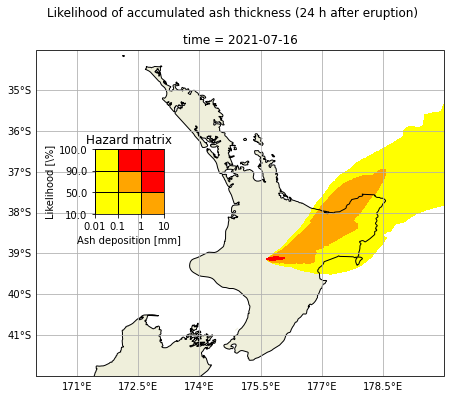

In [15]:
fig, ax = plt.subplots(1,1, figsize=(8,6), subplot_kw={"projection": ccrs.PlateCarree(clon)})    
da = da_risk_it.where(da_risk_it > 0) 
da.plot.contourf(ax=ax, 
                 levels=[0,1,2,3], cmap=cmap_risk,
                 add_colorbar=False,
                 transform=ccrs.PlateCarree())                                            
plot_decor(ax)
ax.set_extent([170,180,-42,-34])
fig.suptitle('Likelihood of accumulated ash thickness ({} h after eruption)'.format(lag_hours[it]))

# this is an inset axes over the main axes
ins_ax = fig.add_axes([.26, .5, .12, .15])
plot_inset_matrix(ins_ax, ashbins, probbins, cmap_risk)

fileplot = fileplot_prefix + '_hazard_matrix_lag{:02d}.png'.format(lag_hours[it])
print(fileplot)
if savefigs: fig.savefig(fileplot, **fig_args)  
    